In [1]:
import math
import random
import time
import numpy as np
import pandas as pd
import xlwt
from scipy.spatial.distance import cdist
from scipy.cluster.vq import vq
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans  
from sklearn.datasets import make_blobs
from matplotlib.pyplot import *
from pylab import *
import matplotlib.pyplot as plt
####
from util import *
import warnings
warnings.filterwarnings('ignore')

In [5]:
##################
data = 'a1.csv'
##################

Text(0.5, 1.0, 'a1')

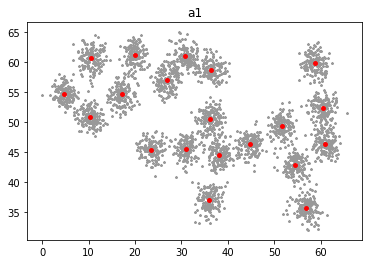

In [6]:
dataMat = pd.read_csv('./Raw_data/all/'+data, header=None, dtype=np.float64).values/1000
plt.scatter(dataMat[:, 0],dataMat[:, 1], s=5, c='0.6', marker='*')
gt = pd.read_csv('./Groundtruth/all/'+data, dtype=np.float64).values/1000
plt.scatter(gt[:, 0],gt[:, 1], s=15, c='r', marker='o')
plt.title(data.strip(".csv"))

In [27]:
class Fmeans:
    def __init__(self, ofm_method='std', 
                       mfo_method='distance', 
                       init_method='random', 
                       radius_method='min', 
                       maxIter=50, 
                       start_epsilon=0.1,
                       ofm_adapt_shape=False, 
                       mfo_adapt_shape=False):
        
        self.init_method = init_method
        self.ofm_method = ofm_method
        self.mfo_method = mfo_method
        
    def fit(self, X, k, seed):
        store_C, sse, seed, OFM_history, MFO_history = FissionFusion(X, k, seed, 
                                                           ofm_method=self.ofm_method, 
                                                           mfo_method=self.mfo_method,
                                                           init_method=self.init_method, 
                                                           maxIter=2*k)
    
        
        self.labels_ = compute_Voronoi(X, store_C[-1])
        self.cluster_centers_ = store_C[-1]
        self.inertia_ = sse[-1]
        
    def fit_related(self, X, k, seed, method = 'X-means', start_k=2, kmax=5):
        '''
        method: X-meanx, Alg7, Alg8
        start_k: Applied when method = X-means, control init centroids number
        kmax:    Applied when method = Alg7,    control max split number
        '''
        if method == 'X-means':
            '''
            (2000) X-means: Extending K-means with Efficient Estimation of the Number of Clusters.
            code source: https://github.com/alex000kim/XMeans
            '''
            xm = XMeans()
            xm.fit(X,start_k)
            self.labels_ = compute_Voronoi(X, xm.cluster_centers_)
            self.cluster_centers_ = [xm.cluster_centers_]
            self.inertia_ = [xm.inertia_]
        if method == 'Alg7':
            '''
            (2006) Clustering by the K-Means Algorithm Using a Split and Merge Procedure
            '''
            store_C, sse = Frce_kmeans(X, k, seed=1, kmax=5)
            self.labels_ = compute_Voronoi(X, store_C[-1])
            self.cluster_centers_ = store_C[-1]
            self.inertia_ = sse[-1]
        if method == 'Alg8':
            '''
            (2016) Robust K-means algorithm with automatically splitting and merging clusters and its applications for surveillance data
            '''
            store_C, sse, k_observe = Ds_kmeans(X, k, seed=1, batch_merge=False)
            self.labels_ = compute_Voronoi(X, store_C[-1])
            self.cluster_centers_ = store_C[-1]
            self.inertia_ = sse[-1]        

In [30]:
#Fission-Fusion
X = dataMat
r = Fmeans(ofm_method='radius')
r.fit(X, 20, 0)

In [9]:
#X-means
X = dataMat
r = Fmeans()
r.fit_related(X, 20, 0, method = 'X-means')

In [20]:
#Alg7
X = dataMat
r = Fmeans()
r.fit_related(X, 20, 0, method = 'Alg7')

In [28]:
#Alg8
X = dataMat
r = Fmeans()
r.fit_related(X, 20, 0, method = 'Alg8')

In [29]:
store_C = [r.cluster_centers_]
print(r.inertia_)

12146.257522258931


<Figure size 432x288 with 0 Axes>

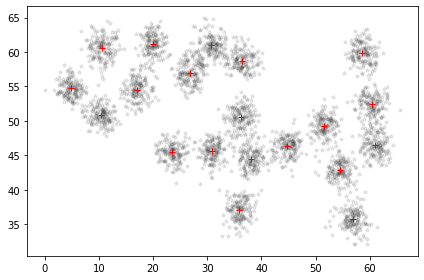

In [30]:
#--------------------------------------------------------------------------------
#------------------------------------Figure--------------------------------------
#--------------------------------------------------------------------------------
figure()
fig = plt.figure()
plot(dataMat[:, 0], dataMat[:, 1], 'k*',markerfacecolor=(0.5, 0.5, 0.5, 0.1), markersize=4)
plot(store_C[-1][:, 0],store_C[-1][:, 1], 'r+')

#adjust entire empty space
fig.tight_layout()

In [ ]:
def FissionFusion(X, K, seed, ofm_method='std', 
                  mfo_method='distance', init_method='random', 
                  radius_method='min', maxIter=50, start_epsilon=0.1,
                  ofm_adapt_shape=False, mfo_adapt_shape=False):
    """
    Proposed Fission Fusion kmeans procedure
    """
    dim = X.shape[1]
    store_C = []
    sse = []
    OFM_history = []
    MFO_history = []
    ### initial kmeans ####
    # make sure no almost empty component 
    while True:
        kms = KMeans(n_clusters=K, init=init_method,n_init=1,random_state=seed,algorithm='full').fit(X)
        labels = kms.labels_
        min_cluster_num = min([np.sum(labels==j) for j in range(K)])
        seed+=1
        if min_cluster_num >=10:
            break
        
    betas = kms.cluster_centers_  
    labels = kms.labels_
    sse.append(kms.inertia_) 
    store_C.append(betas)
    iterCount = 0
    while iterCount < maxIter:
        iterCount+=1
        #####step1: detect OFM #####
        if ofm_method == 'std':
            OFM_index = detect_ofm_std(X, betas, labels, adapt_shape=ofm_adapt_shape)
        elif ofm_method == 'radius':
            OFM_index = detect_ofm_radius(X, betas, labels, radius_method, start_epsilon=start_epsilon)
        elif ofm_method == 'dissimilar':
            OFM_index = Dissimilar(X, betas, labels)         
        OFM_history.append(OFM_index)

        #####step2: Fission #####   
        betas, state = fission(X, betas, labels, OFM_index)
        if state == 'error':
            print ('error')
            return store_C,sse 
        
        labels = compute_Voronoi(X, betas)
        #####step3: detect MFO #####
        if mfo_method == 'distance':
            MFO_index = detect_mfo_distance(X, labels, betas,adapt_shape=mfo_adapt_shape)
        if mfo_method == 'voronoi':
            MFO_index = detect_mfo_Voronoi(X, betas)
        MFO_history.append(MFO_index)
        #####step4 : Fusion #####
        betas = fussion(betas, MFO_index)
        
        assert len(betas) == K # invariance
        
        #####step5: k-means adjustment #####
        kms = KMeans(n_clusters=K, init=betas, random_state=seed, n_init=1).fit(X)
        betas = kms.cluster_centers_
        labels = kms.labels_
        new_sse = kms.inertia_
        if iterCount == 1:
            improvement_ratio = 1
        else:
            improvement_ratio = (sse[-1] - new_sse)/sse[-1]
        
        if improvement_ratio < 0: # objective do not decrease sufficiently 
            break
        else:
            sse.append(kms.inertia_)
            store_C.append(betas)

    return store_C,sse,seed, OFM_history, MFO_history